In [1]:
## Google colab compatible pytorch version 
# !pip uninstall torch -y
# !pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1

In [2]:
from matplotlib import rc
rc('text', usetex=False)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [3]:
import pandas as pd
from ast import literal_eval
import numpy as np
from pickle import dump
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy

In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [5]:
torch.manual_seed(42)
np.random.seed(42)

In [6]:
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

In [7]:
class MyDataset(Dataset):
    def __init__(self, file_name, P_normalizer=None):
        df = pd.read_csv(file_name, sep="\t", converters={"S": literal_eval, "S0": literal_eval, 'P': literal_eval, 'P_init': literal_eval, 'Pb': literal_eval})

        # create features maps
        Pb_dict = df['Pb']
        Pb_list = [pb_l['left'] for pb_l in Pb_dict]
        Pb = torch.from_numpy(np.array([np.full((100, 1), pb_l) for pb_l in Pb_list]))

        S0 = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in df['S0'].values]))
        P0 = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in df['P_init'].values]))

        P = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in df['P'].values]))
        S = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in df['S'].values]))

        # Pb = torch.log10(Pb)
        # P0 = torch.log10(P0)
        # P = torch.log10(P)

        if not P_normalizer:
          P_normalizer = UnitGaussianNormalizer(torch.cat([P, P0, Pb], 0))

        P = P_normalizer.encode(P)
        P0 = P_normalizer.encode(P0)
        Pb = P_normalizer.encode(Pb)

        x = torch.cat([S0, P0, Pb], 2)

        y = torch.cat([S, P], 2)

        self.x_train=x.float()
        self.y_train=y.float()
        self.P_normalizer = P_normalizer


    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

    def normalizers(self):
      return self.P_normalizer

In [8]:
test = MyDataset("data/test.csv")
train = MyDataset("data/train.csv")

In [9]:
BATCH_SIZE=128

In [10]:
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = (
            modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        )

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat)
        )

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-1) // 2 + 1,
            device=x.device,
            dtype=torch.cfloat,
        )
        out_ft[:, :, : self.modes1] = self.compl_mul1d(
            x_ft[:, :, : self.modes1], self.weights1
        )

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO1d(nn.Module):
    def __init__(self, modes, width, n_features):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 6  # pad the domain if input is non-periodic
        self.n_features = n_features

        self.p = nn.Linear(n_features, self.width)
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.q = MLP(self.width, 2, self.width * 2)

    def forward(self, x):
        x = self.p(x)
        x = x.permute(0, 2, 1)

        x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic
        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., : -self.padding]  # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 1)
        return x

In [12]:
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
model = FNO1d(modes = 12, width = 128, n_features=3)
model = model.to(device)

criterion = LpLoss(size_average=False)

lr, momentum = 1e-4 , 0.9

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [15]:
loss_dict = {'train_loss': [], 'val_loss': []}

In [ ]:
epoch_number = len(loss_dict['val_loss'])
EPOCHS = 2500

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train()
    train_loss = 0.

    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels  = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /=  len(train)
    model.eval()

    test_loss = 0.0

    with torch.no_grad():
      for i, vdata in enumerate(test_dataloader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model(vinputs)
          vloss = criterion(voutputs, vlabels)
          test_loss += vloss.item()

    test_loss /= len(test)
    print(f'LOSS train {train_loss:.6f} valid {test_loss:.6f}')
    loss_dict['train_loss'].append(train_loss)
    loss_dict['val_loss'].append(test_loss)
    # keep best model
    if min(loss_dict['val_loss']) == test_loss:
      print(f"New best model at epoch {epoch_number + 1} with test loss {min(loss_dict['val_loss'])}")
      best_model = deepcopy(model)
    epoch_number += 1

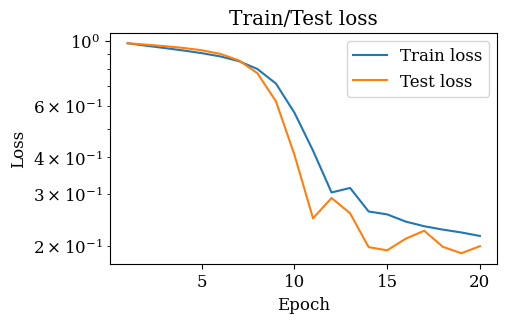

In [17]:
x = list(range(1, len(loss_dict['train_loss'])+1))
fig = plt.plot(figsize=(16,16))
plt.plot(x, loss_dict['train_loss'], label='Train loss')
plt.plot(x, loss_dict['val_loss'], label='Test loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test loss')
plt.legend()
# plt.savefig(f"CEMRACS_Manuscrit_loss_PS.pdf", bbox_inches='tight')
plt.show()

In [18]:
import os
if not os.path.isdir("models"):
    os.mkdir("models")
torch.save(best_model.state_dict(), f"models/checkpoint_best_model_CEMRACS_Manuscrit_{epoch_number}_PS.pt")

P_normalizer = train.normalizers()
dump(P_normalizer, open(f"models/P_normalizer_PS.pkl", 'wb'))
dump(loss_dict, open(f"models/loss_dict_{epoch_number}_PS.pkl", 'wb'))